# Image classification with neural networks
#### Authors: Kristen Lowe and Siboney Cardoso

In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 10 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

* overall test-set accuracy, measured however you think is appropriate
* show some of the example images from the test set, together with your model's predicted classes.
* a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

### Import libraries

In [35]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Load, normalize, and split data 80/20

In [37]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('data/EuroSAT_RGB', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Build a convolutional neural network

This SimpleCNN consists of three convolutional layers (conv1, conv2, and conv3) with increasing filter sizes, each followed by a max pooling layer to reduce spatial dimensions. After the convolutional layers, the output is flattened and passed through three fully connected layers (fc1, fc2, and fc3). The final output layer has 10 units, corresponding to the 10 EuroSAT land use classes. The network uses ReLU activation for intermediate layers and outputs raw scores (logits) for classification.

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

### Train the model

The training loop for the CNN uses the Adam optimizer and a cross-entropy loss function. It iterates through the data over 10 epochs, and prints average loss for each epoch.

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

Epoch 1, Loss: 1.0133
Epoch 2, Loss: 0.6145
Epoch 3, Loss: 0.4350
Epoch 4, Loss: 0.3210
Epoch 5, Loss: 0.2237
Epoch 6, Loss: 0.1489
Epoch 7, Loss: 0.1137
Epoch 8, Loss: 0.0875
Epoch 9, Loss: 0.0848
Epoch 10, Loss: 0.0676


### Evaluate model on test set

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test set accuracy: {accuracy*100:.2f}%')

Test set accuracy: 85.61%


### Create confusion matrix

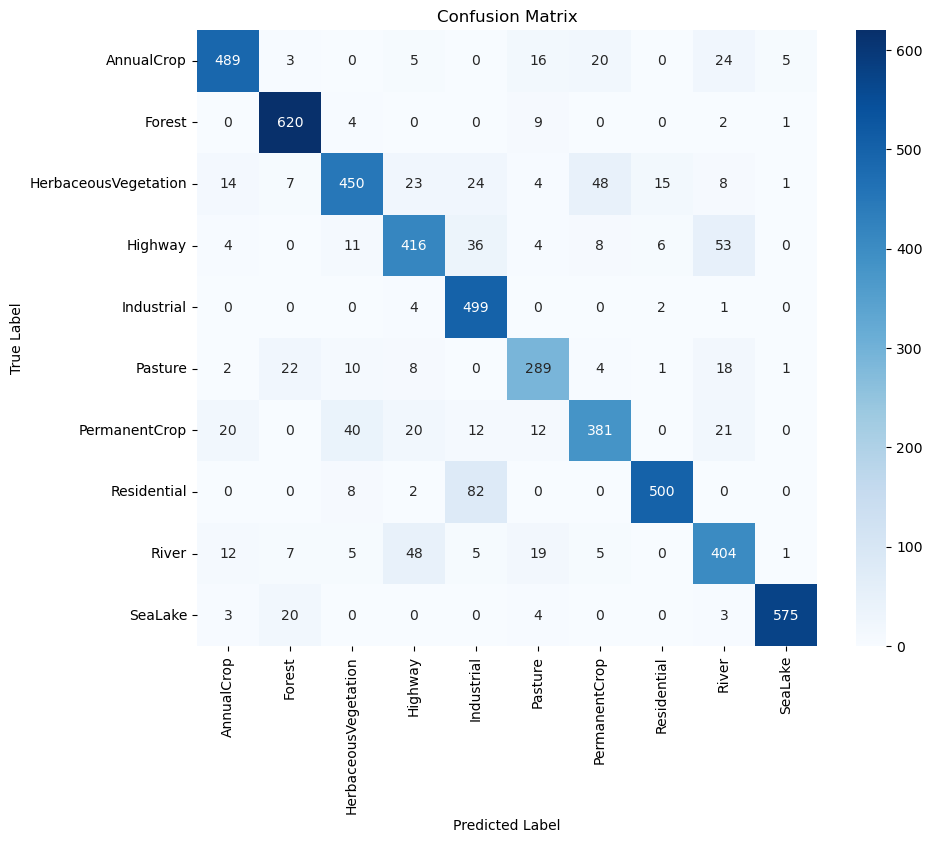

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Example images

Show some of the example images from the test set, together with the model's predicted classes.

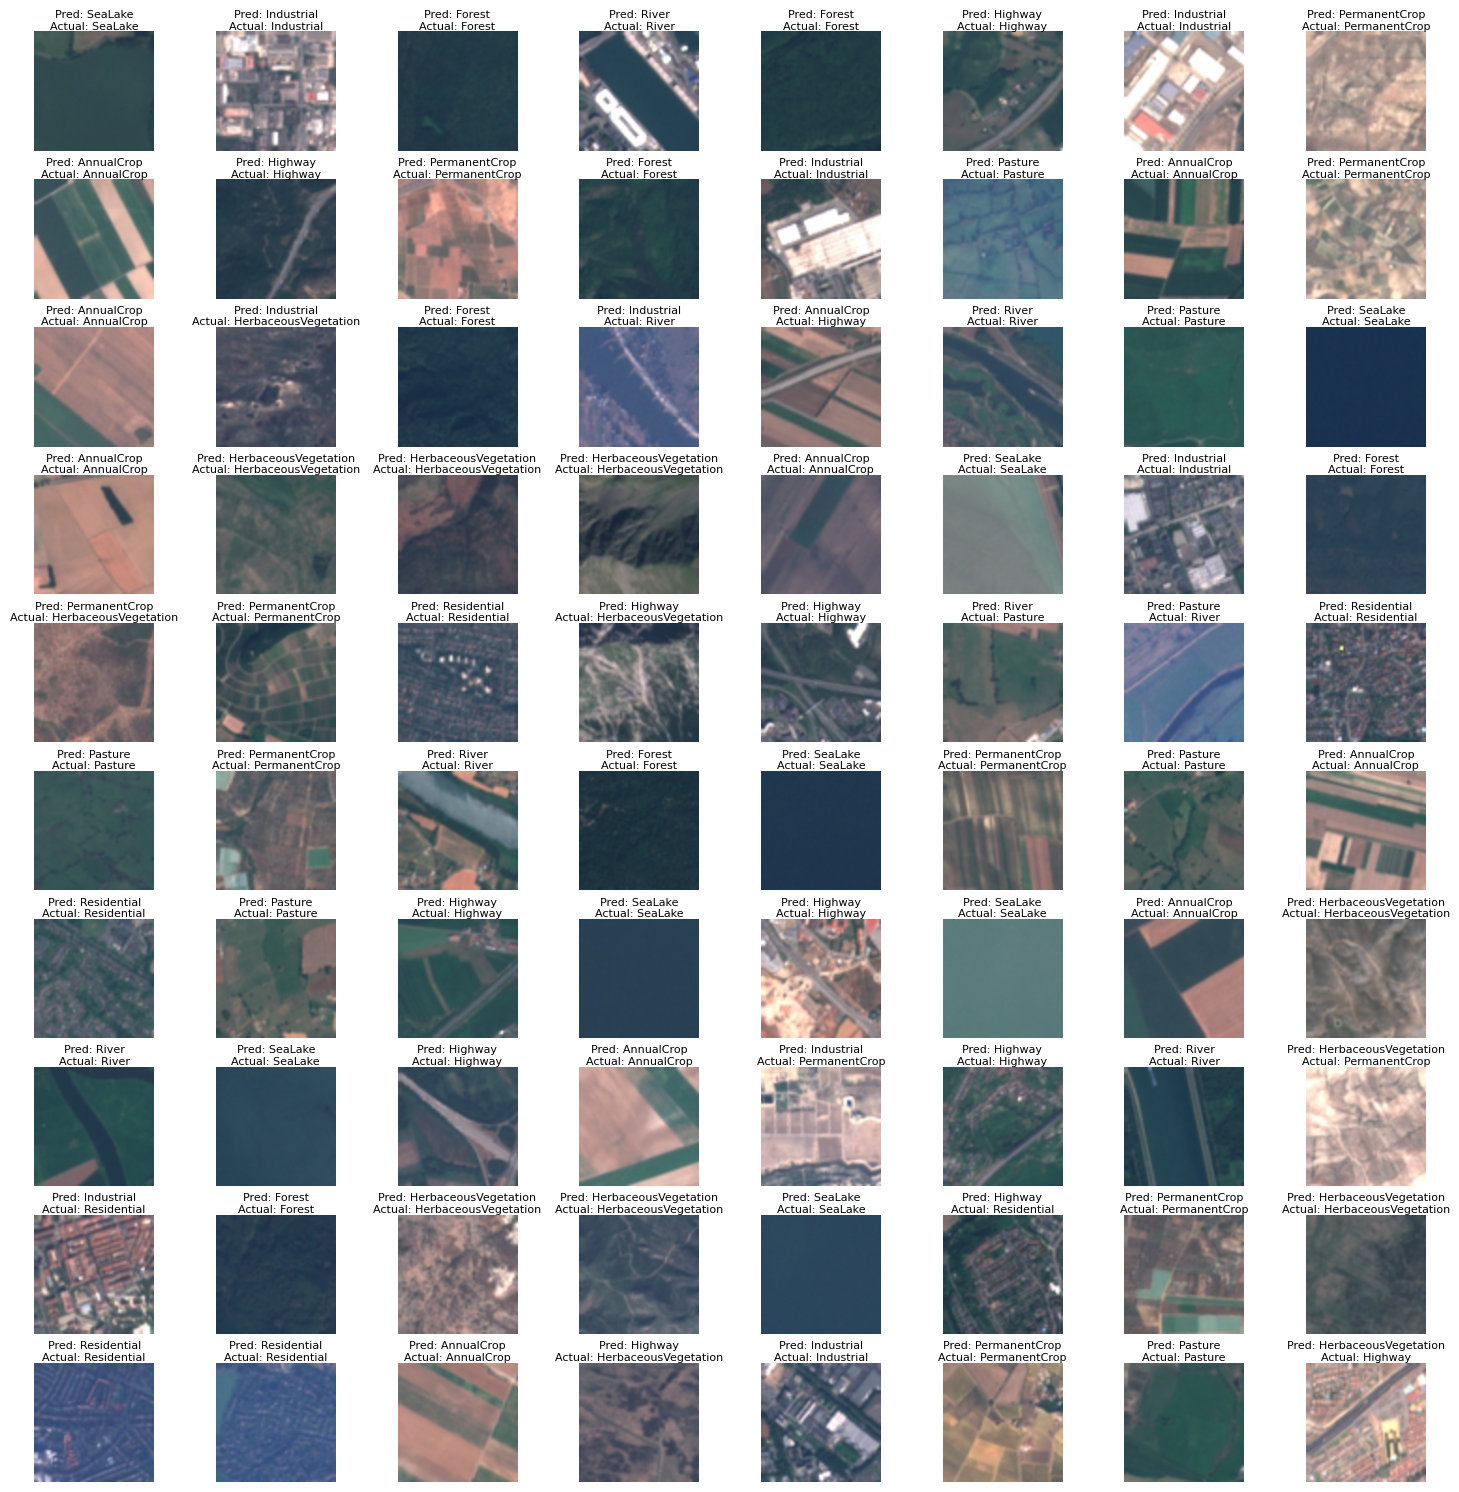

In [96]:
import torch
import matplotlib.pyplot as plt

def denormalize(tensor, mean, std):
    # Convert mean and std to tensors and reshape for broadcasting
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    
    # Denormalize the images
    tensor = tensor * std + mean
    return tensor

def show_images(images, labels, preds, classes):
    # Denormalize the images
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    images = denormalize(images, mean, std)
    
    # Clip images to valid range [0, 1] for display
    images = torch.clamp(images, 0, 1)
    
    plt.figure(figsize=(15, 15))
    num_images = len(images)
    for idx in range(num_images):
        plt.subplot(10, 8, idx + 1)  # 10 rows, 10 columns
        plt.imshow(images[idx].permute(1, 2, 0).cpu())  # Convert CHW to HWC and ensure it's on CPU
        plt.axis('off')
        plt.title(f'Pred: {classes[preds[idx]]}\nActual: {classes[labels[idx]]}', fontsize=8, pad=0.5)
    
    # Adjust spacing to prevent overlap
    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
    plt.show()

# Create a list to store images, actual labels, and predicted labels
images_list = []
labels_list = []
preds_list = []

# Iterate over the test loader to get a batch of images
for images, labels in test_loader:
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
    # Store images, labels, and predictions
    images_list.extend(images.cpu())
    labels_list.extend(labels.cpu())
    preds_list.extend(preds.cpu())

    # Break after collecting enough images
    if len(images_list) >= 80:  # 10 rows * 10 columns
        break

# Convert lists to tensors
images_tensor = torch.stack(images_list[:80])
labels_tensor = torch.tensor(labels_list[:80])
preds_tensor = torch.tensor(preds_list[:80])

# Show images with labels and predictions
show_images(images_tensor, labels_tensor, preds_tensor, dataset.classes)


### Summary

This simple convolutional neural network achieved an accuracy rate of 85.61% in classifying satellite images. However, the model showed some confusion between certain classes. Notable misclassifications included:

* Residential vs. Industrial
* Highway vs. River
* Herbaceous Vegetation vs. Permanent Crop

These insights highlight areas where the model's performance can be improved, potentially by fine-tuning or using more advanced techniques.

In [99]:
# This code was assisted by ChatGPT, an AI language model by OpenAI.
# For more information, visit: https://www.openai.com/chatgpt